### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

sys.path.append("..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [4]:
from src.load_datasets import load_climate_change_data


dataframe = (
    load_climate_change_data()
    .pipe(format_datetime, col="Date Time")
    .pipe(set_index, col="Date Time")
    .pipe(resample_data, freq="H")
    .pipe(interpolate_column)
)

print(f"dataframe shape {dataframe.shape}")

dataframe = dataframe[
    ["p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)"]
].copy(deep=True)

dataframe.head()

format_datetime: DF Shape (420551, 15)
set_index: DF Shape (420551, 14)
resample_Data: DF Shape (70129, 14)
interpolate_columns: DF Shape (70129, 14)
dataframe shape (70129, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%)
Date Time,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333


### test_train_split

train_xy and test_xy size: (70114, 5), (15, 5)

y_train and x_train size (70114,), (70114, 4)
y_test  and x_test  size (15,),  (15, 4)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Tdew (degC)'>)

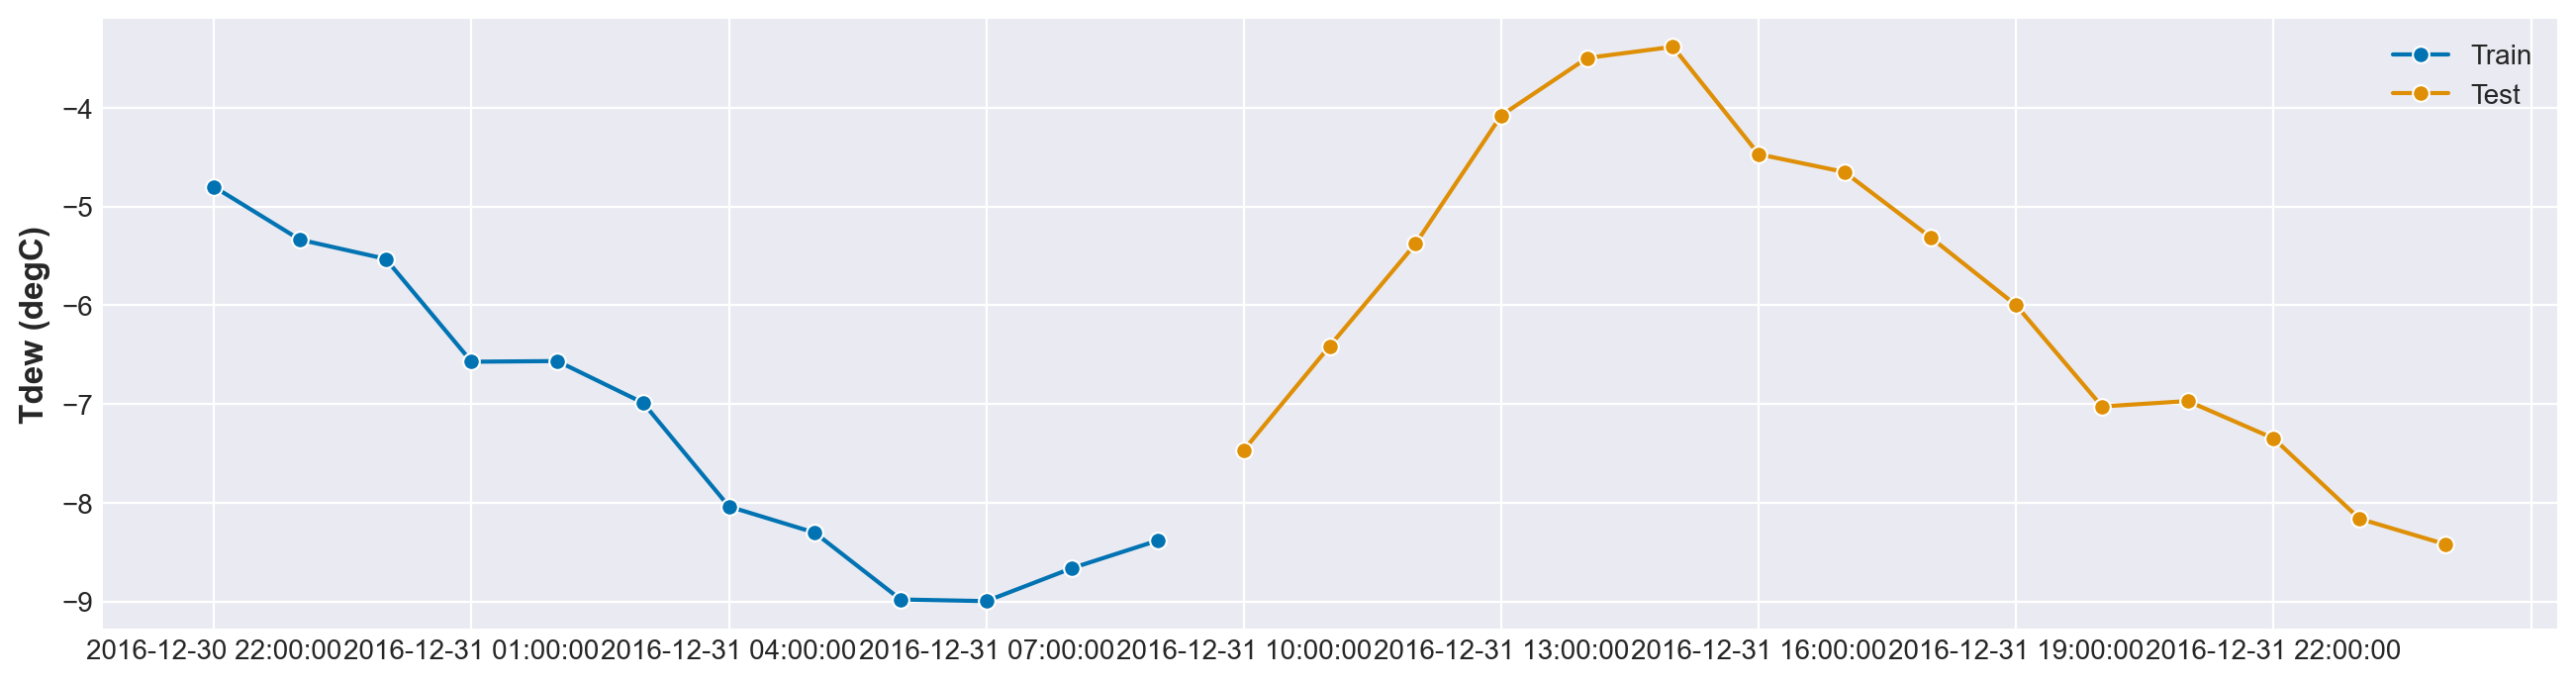

In [6]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "Tdew (degC)"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(12), y_test, labels=["Train", "Test"])

In [8]:
import joblib

trained_model = joblib.load("../results/ridge.pkl")


model_n_features_in = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = trained_model.get_fitted_params()["forecaster__reducer__estimator__coef"]
model_intercept = trained_model.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_coeff {model_coeff}", end="\n\n")
print(f"model_intercept {model_intercept}", end="\n\n")

model_n_features_in 28

model_fname_in ['Tdew (degC)_lag_1' 'Tdew (degC)_lag_2' 'Tdew (degC)_lag_3'
 'Tdew (degC)_lag_4' 'Tdew (degC)_lag_5' 'Tdew (degC)_lag_6'
 'Tdew (degC)_lag_7' 'Tdew (degC)_lag_8' 'Tdew (degC)_lag_9'
 'Tdew (degC)_lag_10' 'Tdew (degC)_lag_11' 'Tdew (degC)_lag_12'
 'Tdew (degC)_lag_13' 'Tdew (degC)_lag_14' 'Tdew (degC)_lag_15'
 'Tdew (degC)_lag_16' 'Tdew (degC)_lag_17' 'Tdew (degC)_lag_18'
 'Tdew (degC)_lag_19' 'Tdew (degC)_lag_20' 'Tdew (degC)_lag_21'
 'Tdew (degC)_lag_22' 'Tdew (degC)_lag_23' 'Tdew (degC)_lag_24' 'p (mbar)'
 'T (degC)' 'Tpot (K)' 'rh (%)']

model_coeff [ 5.16146981e-01 -3.29301609e-02 -6.47241972e-03 -8.97937710e-03
 -1.36456721e-03 -1.91484491e-03 -7.54635295e-04 -1.32916418e-03
 -3.28160567e-03 -6.42335659e-03  3.55703143e-03 -1.13226073e-03
  2.89605511e-03  2.24197470e-04 -6.11471528e-04  7.92887006e-04
 -1.15377393e-03  2.94919543e-03 -1.89483327e-04 -2.37499735e-04
  8.59985396e-04  3.52657863e-03  4.92348702e-03 -5.62801177e-03
 -9.0520538

In [9]:
print(x_test.columns)

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'rh (%)'], dtype='object')


### Forecasting

C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.w

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Tdew (degC)'>)

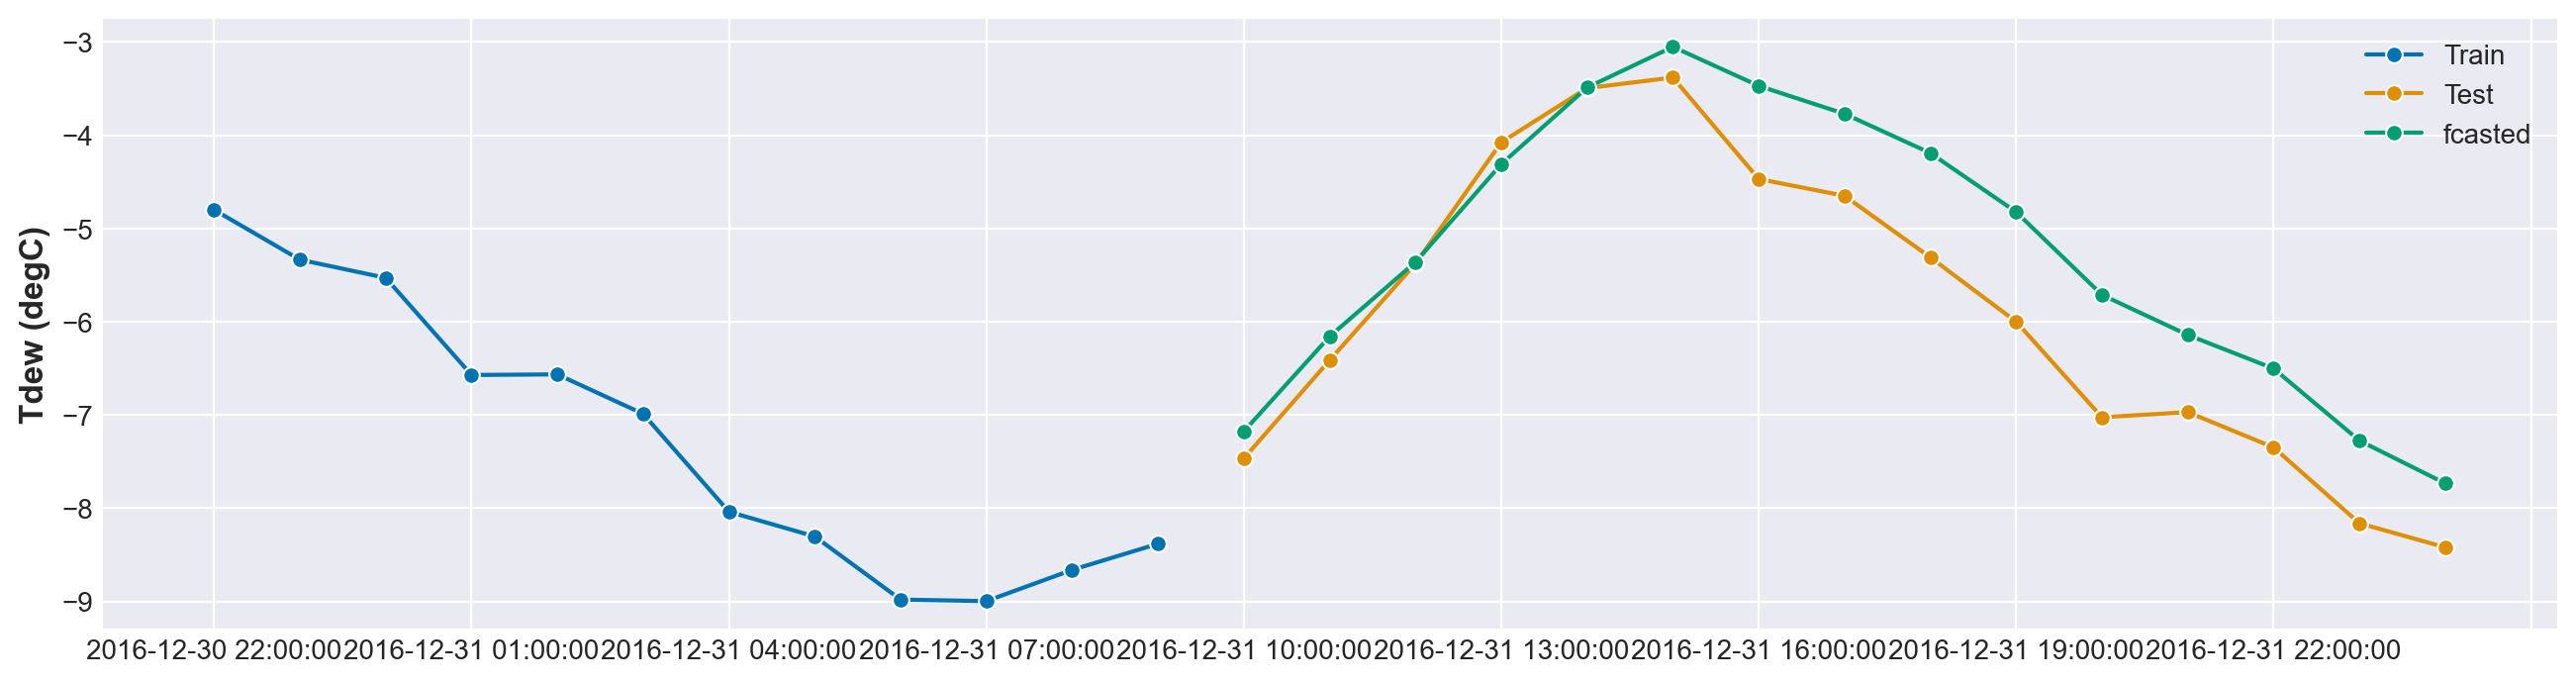

In [10]:
fh = np.arange(1, TEST_SIZE + 1)

y_fcasted = trained_model.predict(fh, X=x_test)

plot_series(y_train.tail(12), y_test, y_fcasted, labels=["Train", "Test", "fcasted"])

In [11]:
print(trained_model.cutoff)

DatetimeIndex(['2016-12-31 09:00:00'], dtype='datetime64[ns]', name='Date Time', freq='H')


In [12]:
x_test.head()

,p (mbar),T (degC),Tpot (K),rh (%)
Date Time,,,,
2016-12-31 10:00:00,1005.878333,-4.650000,268.060000,80.533333
2016-12-31 11:00:00,1005.196667,-2.726667,270.031667,75.666667
2016-12-31 12:00:00,1004.346667,0.218333,273.041667,65.935000
2016-12-31 13:00:00,1003.616667,2.555000,275.430000,61.498333
2016-12-31 14:00:00,1003.150000,4.618333,277.528333,55.488333


### No Input Graurd in Fitted Model 

In [13]:
x_modified = x_test[["press", "wnd_spd", "snow", "rain", "dewp", "temp"]]
x_modified.head()

KeyError: "None of [Index(['press', 'wnd_spd', 'snow', 'rain', 'dewp', 'temp'], dtype='object')] are in the [columns]"

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

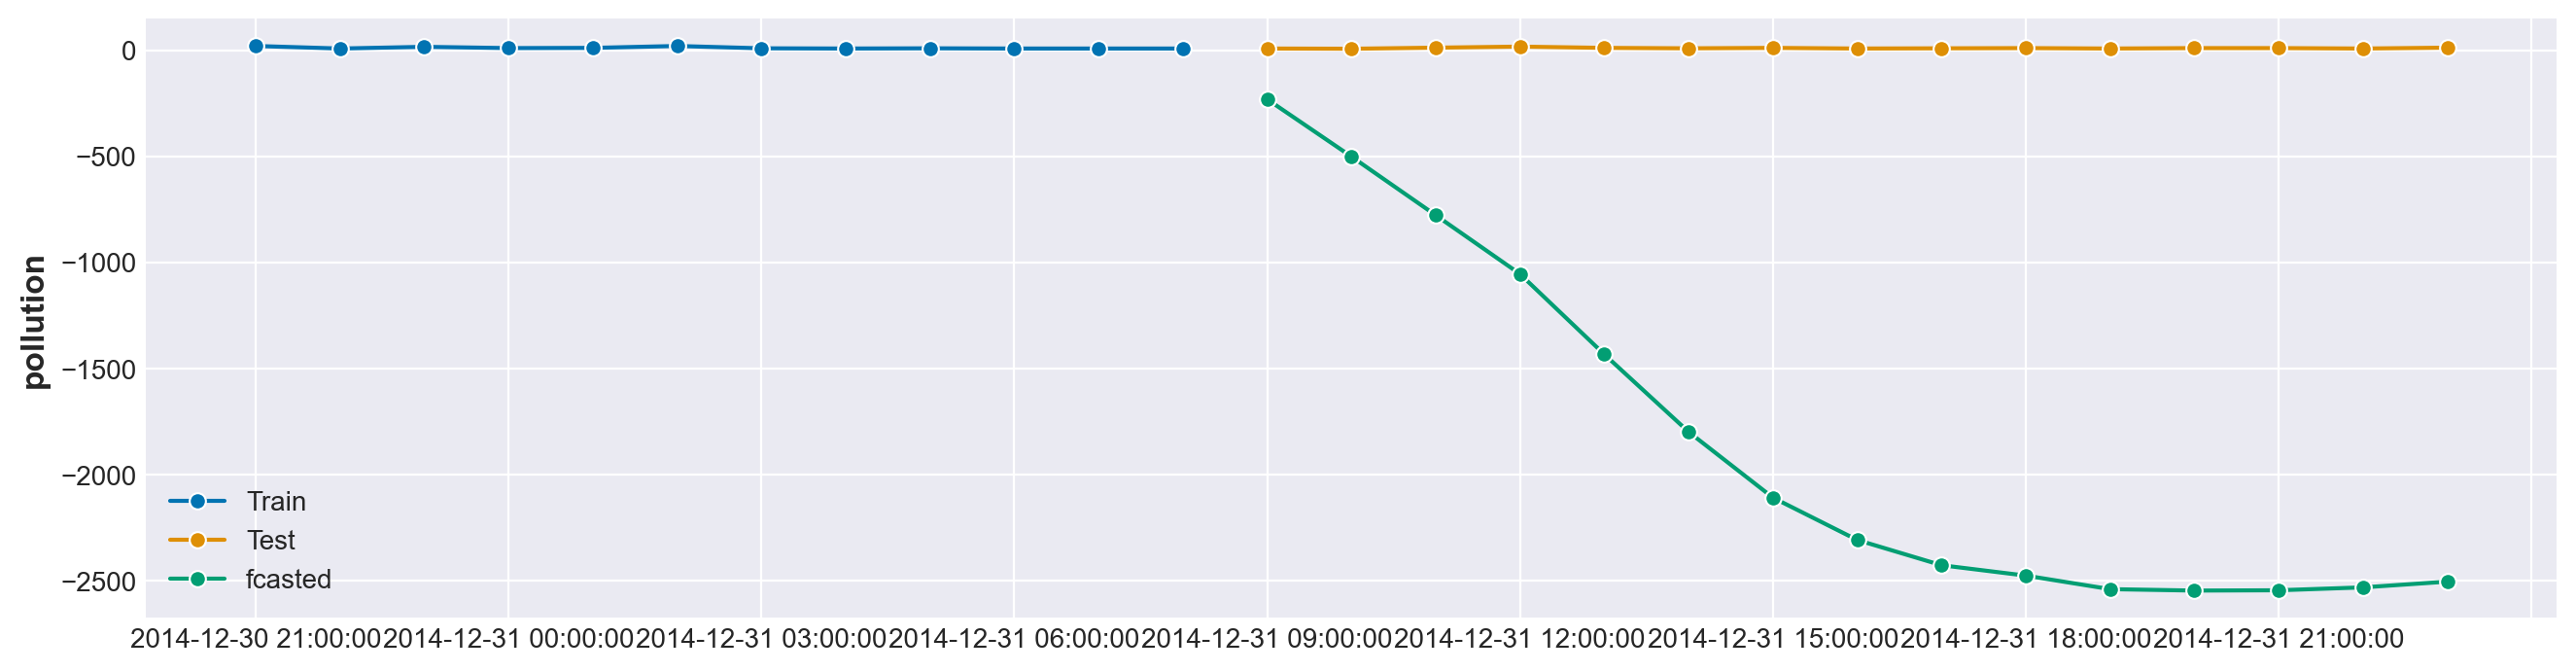

In [22]:
fh = np.arange(1, TEST_SIZE + 1)

y_fcasted = trained_model.predict(fh, X=x_modified)

plot_series(y_train.tail(12), y_test, y_fcasted, labels=["Train", "Test", "fcasted"])